In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from torchsummary import summary

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
# 데이터셋 인스턴스 생성
data = pd.read_csv('https://raw.githubusercontent.com/Kim-TaeWook/AI-class/refs/heads/main/week6/diabetes.csv')  # CSV 파일 경로

In [3]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

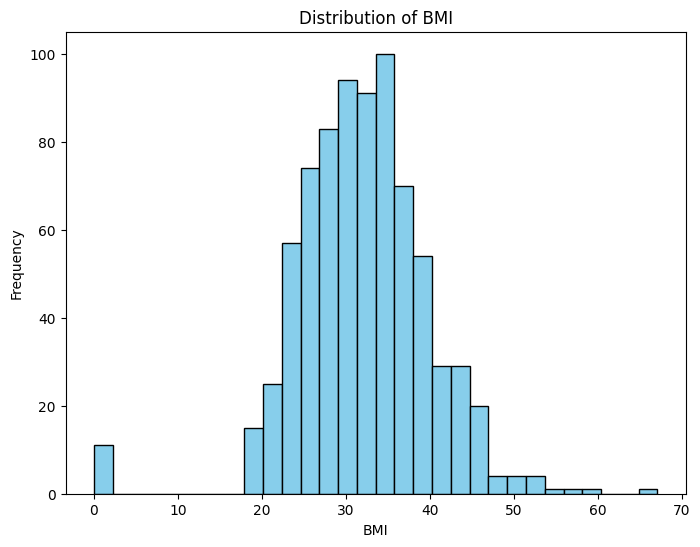

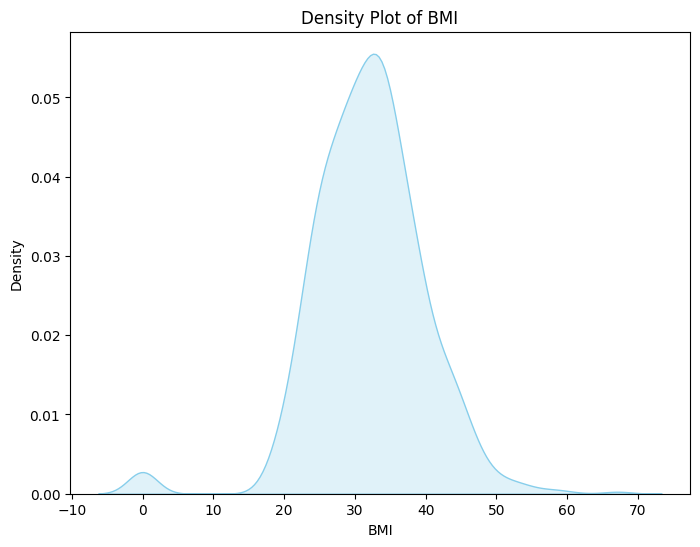

In [5]:
# Histogram 예시
plt.figure(figsize=(8, 6))
plt.hist(data["BMI"], bins=30, color='skyblue', edgecolor='black')
plt.xlabel("BMI")
plt.ylabel("Frequency")
plt.title("Distribution of BMI")
plt.show()

# KDE plot 예시 (Seaborn 이용)
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.kdeplot(data["BMI"], fill=True, color='skyblue')
plt.xlabel("BMI")
plt.ylabel("Density")
plt.title("Density Plot of BMI")
plt.show()

In [6]:
# 데이터와 타겟 분리
# 회귀 문제에서는 Outcome은 분류용이므로 타겟에서 제외하고,
# BMI를 타겟으로 사용합니다.
# 입력 특징은 BMI와 Outcome을 제외한 나머지 컬럼들입니다.
X = data.drop(['BMI', 'Outcome'], axis=1).values  # 예: Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, DiabetesPedigreeFunction, Age
y = data['BMI'].values  # 타겟: BMI

In [7]:
# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)


# 학습/테스트 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [8]:
print("Train shapes:", X_train.shape, y_train.shape)

Train shapes: (614, 7) (614,)


In [9]:
print("Test shapes:", X_test.shape, y_test.shape)

Test shapes: (154, 7) (154,)


In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((614, 7), (154, 7), (614,), (154,))

In [11]:
# PyTorch 텐서 변환 및 CNN 입력 형태로 재구성

# 현재 X_train의 shape는 (n_samples, n_features) 예: (?, 7)
# CNN을 적용하기 위해 각 샘플을 1채널의 1D 시퀀스로 재구성: (n_samples, channels=1, sequence_length=n_features)
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # shape: (N, 1, 7)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # shape: (N, 1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [12]:
# DataLoader 생
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 1, 7]),
 torch.Size([154, 1, 7]),
 torch.Size([614, 1]),
 torch.Size([154, 1]))

## **모델 정의**

In [14]:
# CNN 모델 정의 (회귀용)
class DiabetesCNNRegression(nn.Module):
    def __init__(self):
        super(DiabetesCNNRegression, self).__init__()
        # 입력: (batch, channels=1, sequence_length=number_of_features) → 여기서 n_features=7
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # 컨볼루션 층에서 stride=1, padding=1이면 시퀀스 길이는 그대로 유지됨 → (batch, 32, 7)
        self.fc1 = nn.Linear(32 * 7, 64)
        self.fc2 = nn.Linear(64, 1)  # 회귀 문제이므로 출력 1개
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))   # (batch, 16, 7)
        x = self.relu(self.conv2(x))   # (batch, 32, 7)
        x = x.view(x.size(0), -1)        # Flatten → (batch, 32*7)
        x = self.relu(self.fc1(x))       # (batch, 64)
        x = self.fc2(x)                  # (batch, 1)
        return x

model = DiabetesCNNRegression()
print(model)

DiabetesCNNRegression(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=224, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


## **손실 함수 및 최적화 기법 정의**

In [15]:
# 손실함수 및 최적화기 설정 (회귀용: MSELoss)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## **모델 학습**

In [16]:
# 학습 변수 초기화
num_epochs = 50
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    
print("Training complete.")

Epoch 1/50, Loss: 1063.5905
Epoch 2/50, Loss: 773.2091
Epoch 3/50, Loss: 210.1219
Epoch 4/50, Loss: 124.7907
Epoch 5/50, Loss: 98.4610
Epoch 6/50, Loss: 84.6436
Epoch 7/50, Loss: 73.6058
Epoch 8/50, Loss: 65.7943
Epoch 9/50, Loss: 59.6193
Epoch 10/50, Loss: 55.8672
Epoch 11/50, Loss: 53.6226
Epoch 12/50, Loss: 51.3927
Epoch 13/50, Loss: 49.7268
Epoch 14/50, Loss: 48.9479
Epoch 15/50, Loss: 48.2822
Epoch 16/50, Loss: 46.9573
Epoch 17/50, Loss: 46.7011
Epoch 18/50, Loss: 46.3715
Epoch 19/50, Loss: 45.4969
Epoch 20/50, Loss: 45.1457
Epoch 21/50, Loss: 45.1131
Epoch 22/50, Loss: 44.5003
Epoch 23/50, Loss: 44.0475
Epoch 24/50, Loss: 44.7566
Epoch 25/50, Loss: 44.2400
Epoch 26/50, Loss: 43.6983
Epoch 27/50, Loss: 43.1132
Epoch 28/50, Loss: 43.0066
Epoch 29/50, Loss: 42.8269
Epoch 30/50, Loss: 42.4899
Epoch 31/50, Loss: 42.0912
Epoch 32/50, Loss: 42.8662
Epoch 33/50, Loss: 42.0818
Epoch 34/50, Loss: 42.9856
Epoch 35/50, Loss: 42.0832
Epoch 36/50, Loss: 41.1182
Epoch 37/50, Loss: 40.6256
Epoch

## **모델 평가**

In [17]:
# Evaluation
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for inputs, targets in test_dataloader:
        outputs = model(inputs)
        all_preds.extend(outputs.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

all_preds = np.array(all_preds).flatten()
all_targets = np.array(all_targets).flatten()

mse = mean_squared_error(all_targets, all_preds)
r2 = r2_score(all_targets, all_preds)
print(f"Test MSE: {mse:.4f}")
print(f"Test R^2 Score: {r2:.4f}")

Test MSE: 46.3098
Test R^2 Score: 0.2198


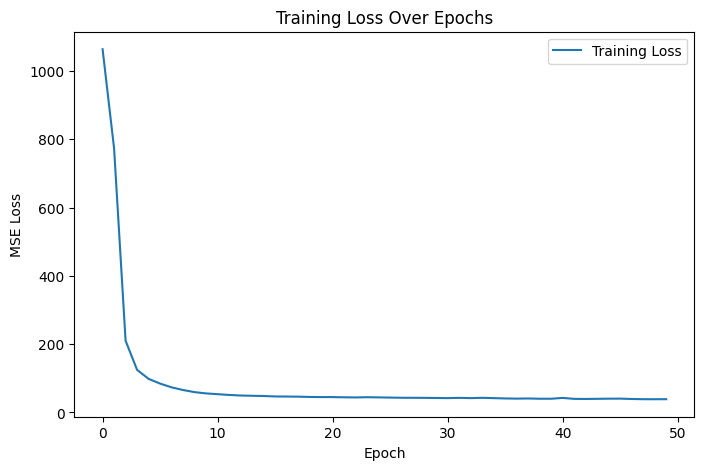

In [18]:
# Plot the loss and accuracy
plt.figure(figsize=(8, 5))

# Plot loss
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()